In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as nnf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

%matplotlib notebook

torch.set_default_dtype(torch.float64)

In [2]:
def is_array(X):
    return isinstance(X, (list, tuple, np.ndarray))

In [3]:
degree = 3
K = torch.tensor([i for i in range(degree)], dtype=torch.float64)

def basis_cos(x):
    if is_array(x):
        return np.cos(np.outer(K, x))
    
    if torch.is_tensor(x):
        return torch.cos(torch.ger(K, x))
    
    return np.cos(x * K)

def basis_sin(x):
    if is_array(x):
        return np.sin(np.outer(K, x))
    
    if torch.is_tensor(x):
        return torch.sin(torch.ger(K, x))
    
    return np.cos(x * K)

class FourierFunction:
    
    def __init__(self, A, B):
        if len(A) != len(K) or len(B) != len(K):
            raise ValueError("Invalid input shape")
        
        self.A = A
        self.B = B
    
    def compute(self, X):
        return (self.A @ basis_cos(X)) + (self.B @ basis_sin(X))
    
    def derive1(self, X):
        return ((self.B * K) @ basis_cos(X)) - ((self.A * K) @ basis_sin(X))
    
    def derive2(self, X):
        return -((self.A * (K**2)) @ basis_cos(X)) - ((self.B * (K**2)) @ basis_sin(X))
    
    def derive3(self, X):
        return -((self.B * (K**3)) @ basis_cos(X)) + ((self.A * (K**3)) @ basis_sin(X))
    
    def derive4(self, X):
        return ((self.A * (K**4)) @ basis_cos(X)) + ((self.B * (K**4)) @ basis_sin(X))



In [4]:
def generate_coefficients():
    lim = 10
    sigma = 0.1
    a, b = -lim/sigma, +lim/sigma 
    A = sigma * truncnorm.rvs(a, b, size=degree)
    B = sigma * truncnorm.rvs(a, b, size=degree)
    return torch.from_numpy(A), torch.from_numpy(B)

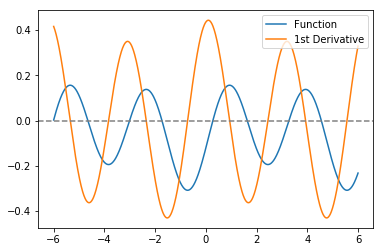

In [5]:
# Test FourierFunction and its derivatives
debug_func = True
X = torch.linspace(-6, 6, 1000)
if debug_func:
    A, B = generate_coefficients()
    func = FourierFunction(A, B)
    plt.plot(X.numpy(), func.compute(X).numpy(), label="Function")
    plt.plot(X.numpy(), func.derive1(X).numpy(), label="1st Derivative")
    plt.axhline(color='gray', linestyle='--')
    plt.legend()
    plt.show()

In [61]:
class DerivativeNet(nn.Module):

    def __init__(self):
        super(DerivativeNet, self).__init__()
        self.fct1 = nn.Linear(1000, 3000)
        self.fct2 = nn.Linear(3000, 1000)

    def forward(self, x):
        x = torch.tanh(self.fct1(x))
        x = 10 * self.fct2(x)
        return x

In [62]:
net = DerivativeNet()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001)

A, B = generate_coefficients()
func = FourierFunction(A, B)
target = func.derive1(X)

In [71]:
for epoch in range(0, 10_000+1):
    optimizer.zero_grad()
    output = net(func.compute(X))
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if epoch % 250 == 0:
        print("Epoch "+str(epoch)+": "+("%.6f" % loss.data.item()))
        data = output.detach().numpy()
    
    if epoch == 4500:
        for g in optimizer.param_groups:
            g['lr'] = 0.0001 / 10

Epoch 0: 0.000144
Epoch 250: 0.000140
Epoch 500: 0.000135
Epoch 750: 0.000131
Epoch 1000: 0.000127
Epoch 1250: 0.000123
Epoch 1500: 0.000119
Epoch 1750: 0.000116
Epoch 2000: 0.000112
Epoch 2250: 0.000109
Epoch 2500: 0.000105
Epoch 2750: 0.000102
Epoch 3000: 0.000099
Epoch 3250: 0.000096
Epoch 3500: 0.000093
Epoch 3750: 0.000090
Epoch 4000: 0.000087
Epoch 4250: 0.000084
Epoch 4500: 0.000082
Epoch 4750: 0.000079
Epoch 5000: 0.000077
Epoch 5250: 0.000074
Epoch 5500: 0.000072
Epoch 5750: 0.000070
Epoch 6000: 0.000068
Epoch 6250: 0.000066
Epoch 6500: 0.000064
Epoch 6750: 0.000062
Epoch 7000: 0.000060
Epoch 7250: 0.000058
Epoch 7500: 0.000056
Epoch 7750: 0.000054
Epoch 8000: 0.000053
Epoch 8250: 0.000051
Epoch 8500: 0.000049
Epoch 8750: 0.000048
Epoch 9000: 0.000046
Epoch 9250: 0.000045
Epoch 9500: 0.000044
Epoch 9750: 0.000042
Epoch 10000: 0.000041


<IPython.core.display.Javascript object>


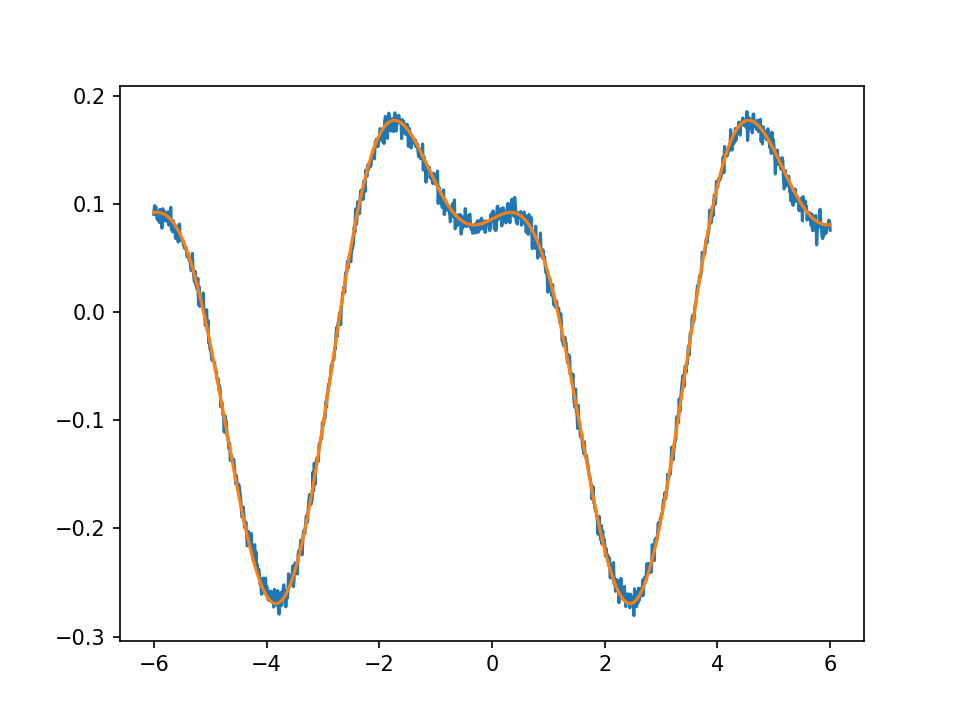

In [73]:
fig2 = plt.figure()
plt.plot(X.numpy(), data)
plt.plot(X.numpy(), target.detach().numpy())
plt.show()